## SARIMA Model Implementation for Burglary Forecasting

### 1. Data Preparation


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [2]:
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv('../data/residential_burglary.csv')

# Combine 'Year' and 'Month' into a single datetime column
df['Month'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str), format='%Y-%m')

# Aggregate to monthly counts
monthly_counts = df.resample('M', on='Month').size().to_frame(name='burglary_count')

# Fill potential missing months (adds 0 for months with no burglaries)
full_index = pd.date_range(start=monthly_counts.index.min(),
                          end=monthly_counts.index.max(),
                          freq='M')
monthly_counts = monthly_counts.reindex(full_index, fill_value=0)

print(monthly_counts)


            burglary_count
2013-12-31            7018
2014-01-31            7233
2014-02-28            6221
2014-03-31            6179
2014-04-30            5418
...                    ...
2024-10-31            4005
2024-11-30            4073
2024-12-31            4211
2025-01-31            3913
2025-02-28            3262

[135 rows x 1 columns]


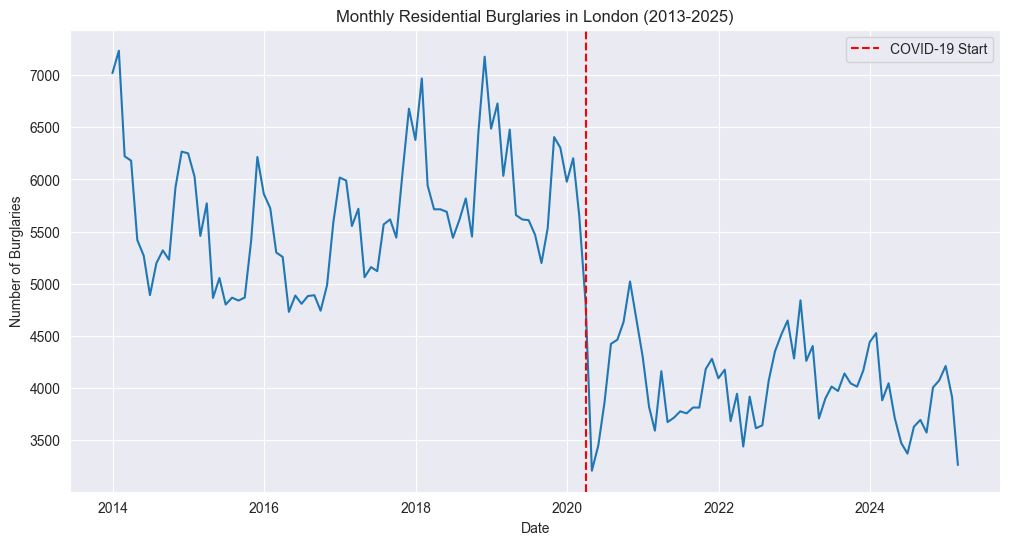

In [3]:
# Visualize the full series
plt.figure(figsize=(12, 6))
plt.plot(monthly_counts.index, monthly_counts.burglary_count)
plt.title('Monthly Residential Burglaries in London (2013-2025)')
plt.xlabel('Date')
plt.ylabel('Number of Burglaries')
plt.grid(True)
plt.axvline(pd.Timestamp('2020-03-31'), color='red', linestyle='--', label='COVID-19 Start')
plt.legend()
plt.show()


### 2. Stationarity Check and Differencing


ADF Statistic (Full Data ADF Statistic): -8.587
p-value: 0.000


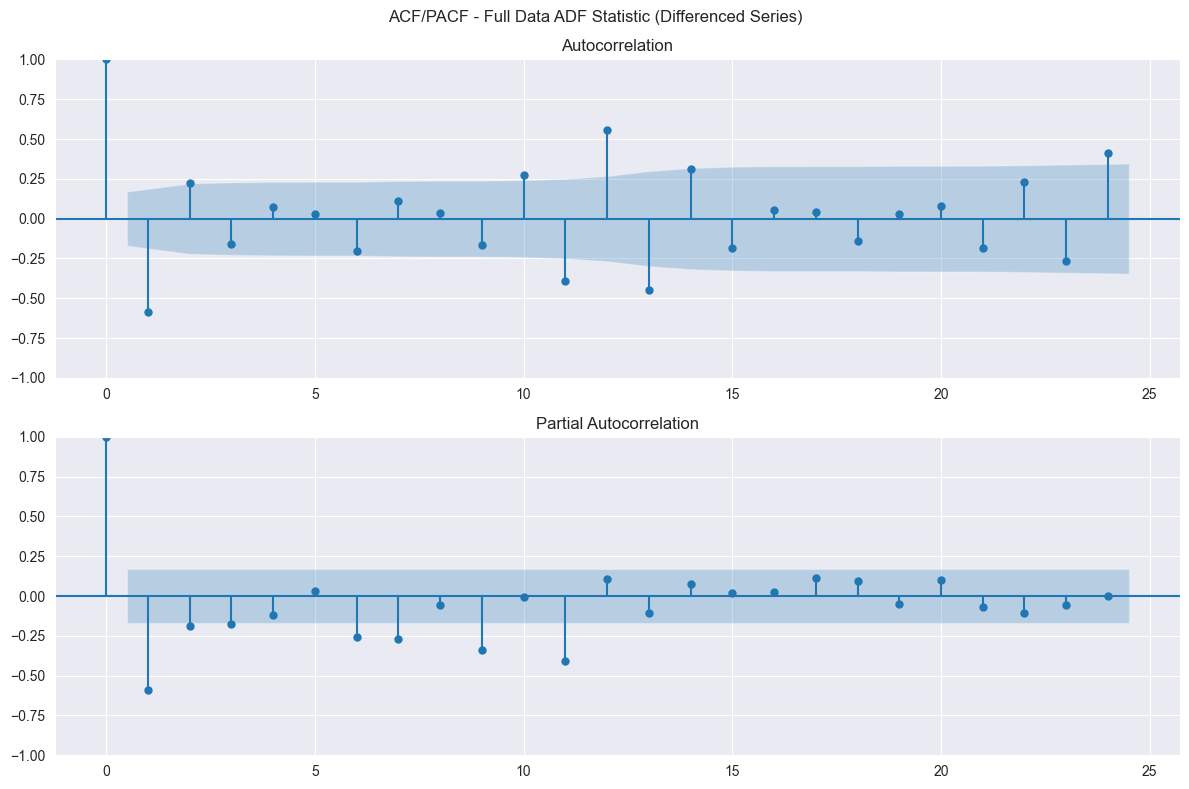

In [4]:
# Augmented Dickey-Fuller test
def plot_diff_acf_pacf(series, title):
    # First difference
    diff = series.diff().dropna()

    # ADF test
    result = adfuller(diff)
    print(f'ADF Statistic ({title}): {result[0]:.3f}')
    print(f'p-value: {result[1]:.3f}')

    # Plot ACF/PACF
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))
    plot_acf(diff, lags=24, ax=ax1)
    plot_pacf(diff, lags=24, ax=ax2, method='ywm')
    plt.suptitle(f'ACF/PACF - {title} (Differenced Series)')
    plt.tight_layout()
    plt.show()

diff = monthly_counts.diff().dropna()
plot_diff_acf_pacf(diff.burglary_count, 'Full Data ADF Statistic')

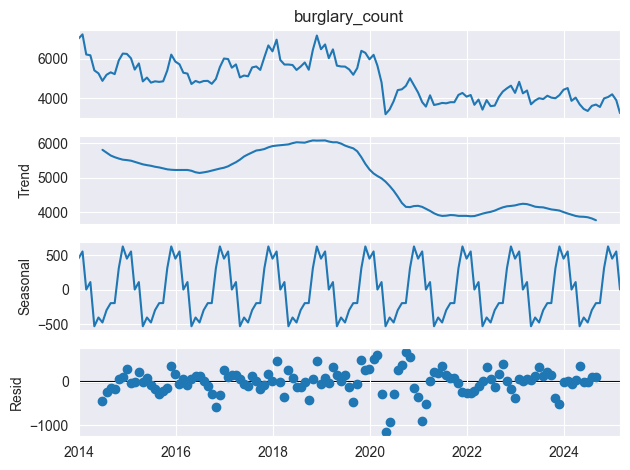

In [5]:
# Seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(monthly_counts.burglary_count, period=12)  # Annual seasonality
decomposition.plot()
plt.show()


### 3. SARIMA Model Training


In [6]:
# Split data into train/test
train = monthly_counts[:'2022-12-31']
test = monthly_counts['2023-01-31':]  # Our test set is 2023-2025

# Fit SARIMA model (parameters determined through grid search)
order = (2, 1, 1)
seasonal_order = (2, 1, 1, 12)

model = SARIMAX(train,
               order=order,
               seasonal_order=seasonal_order,
               enforce_stationarity=False,
               enforce_invertibility=False)

results = model.fit(disp=False)

# Model summary
print(results.summary())


                                     SARIMAX Results                                      
Dep. Variable:                     burglary_count   No. Observations:                  109
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -510.134
Date:                            Sat, 07 Jun 2025   AIC                           1034.267
Time:                                    20:51:03   BIC                           1050.007
Sample:                                12-31-2013   HQIC                          1040.519
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1400      0.435     -0.321      0.748      -0.993       0.714
ar.L2         -0.2559      0.120   

### 4. Model Validation


In [7]:
# Forecast validation period
forecast_steps = len(test)
forecast = results.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
confidence_int = forecast.conf_int()

# Calculate metrics
mse = mean_squared_error(test, forecast_mean)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, forecast_mean)

print(f'Validation Metrics:\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}')


Validation Metrics:
RMSE: 402.37
MAE: 360.86


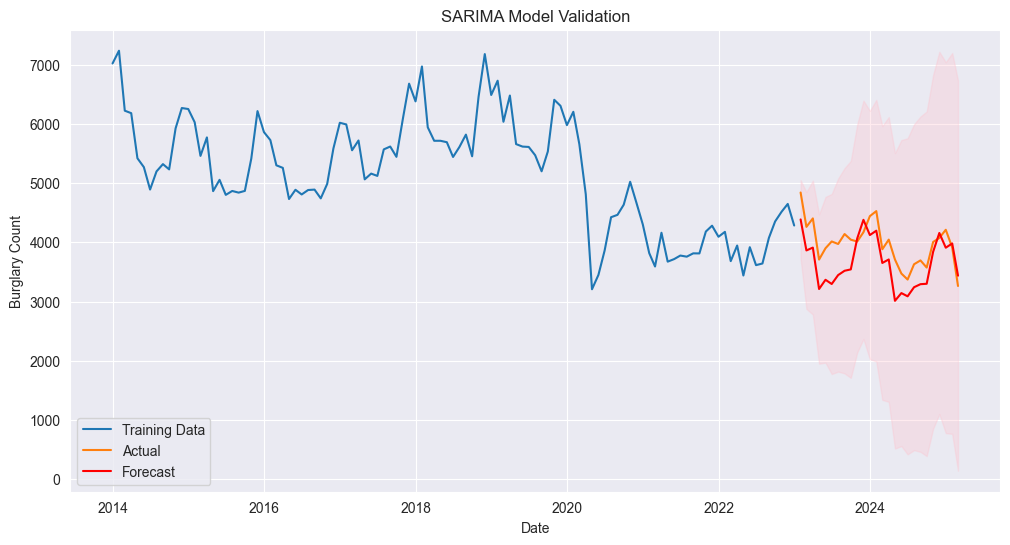

In [8]:
# Plot validation
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast_mean, label='Forecast', color='red')
plt.fill_between(test.index,
                confidence_int.iloc[:, 0],
                confidence_int.iloc[:, 1], 
                color='pink', alpha=0.3)
plt.title('SARIMA Model Validation')
plt.xlabel('Date')
plt.ylabel('Burglary Count')
plt.legend()
plt.show()


### 5. Future Forecasting (2026)


In [9]:
# Forecast 2026
future_steps = 22
full_model = SARIMAX(monthly_counts, 
                    order=order, 
                    seasonal_order=seasonal_order)
full_results = full_model.fit(disp=False)


In [10]:
# Generate forecast
forecast_2026 = full_results.get_forecast(steps=future_steps)
forecast_mean_2026 = forecast_2026.predicted_mean
forecast_conf_2026 = forecast_2026.conf_int()


In [11]:
# Create date index for 2026
forecast_index = pd.date_range(start=monthly_counts.index[-1] + pd.DateOffset(months=1),
                              periods=future_steps, 
                              freq='M')


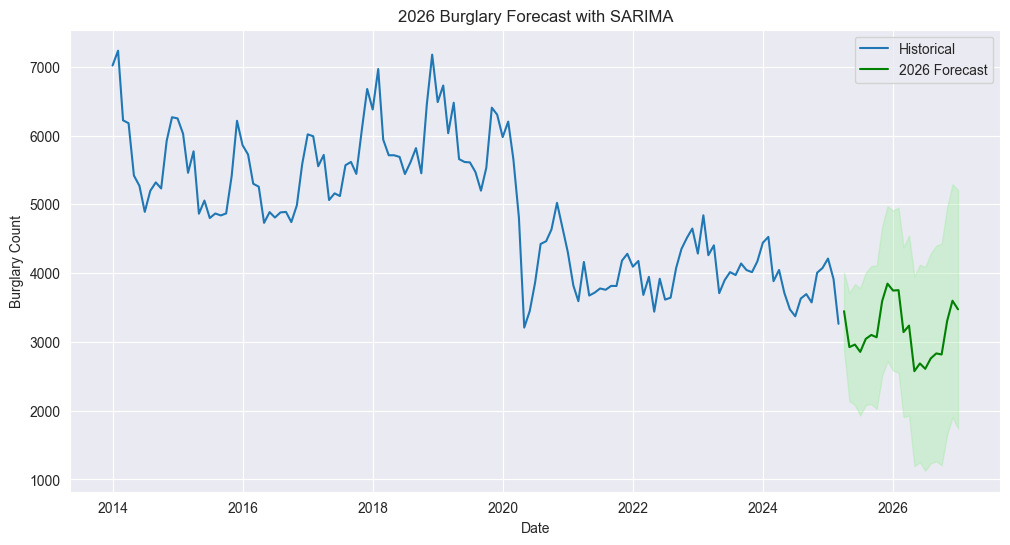

In [12]:
# Plot full series with forecast
plt.figure(figsize=(12, 6))
plt.plot(monthly_counts.index, monthly_counts, label='Historical')
plt.plot(forecast_index, forecast_mean_2026, 
        label='2026 Forecast', color='green')
plt.fill_between(forecast_index,
                forecast_conf_2026.iloc[:, 0],
                forecast_conf_2026.iloc[:, 1],
                color='lightgreen', alpha=0.3)
plt.title('2026 Burglary Forecast with SARIMA')
plt.xlabel('Date')
plt.ylabel('Burglary Count')
plt.legend()
plt.show()


In [13]:
# Print numerical forecast
forecast_2026_df = pd.DataFrame({
    'Month': forecast_index.strftime('%Y-%m'),
    'Predicted_Burglaries': forecast_mean_2026.round(),
    'Lower_CI': forecast_conf_2026.iloc[:, 0].round(),
    'Upper_CI': forecast_conf_2026.iloc[:, 1].round()
})
print("2026 Monthly Forecast:")
print(forecast_2026_df.to_string(index=False))

2026 Monthly Forecast:
  Month  Predicted_Burglaries  Lower_CI  Upper_CI
2025-03                3445.0    2883.0    4008.0
2025-04                2923.0    2136.0    3710.0
2025-05                2960.0    2082.0    3839.0
2025-06                2853.0    1928.0    3778.0
2025-07                3043.0    2080.0    4005.0
2025-08                3100.0    2099.0    4101.0
2025-09                3066.0    2024.0    4109.0
2025-10                3592.0    2507.0    4676.0
2025-11                3846.0    2722.0    4971.0
2025-12                3746.0    2583.0    4909.0
2026-01                3751.0    2551.0    4951.0
2026-02                3141.0    1906.0    4377.0
2026-03                3236.0    1926.0    4547.0
2026-04                2573.0    1193.0    3954.0
2026-05                2686.0    1250.0    4121.0
2026-06                2608.0    1126.0    4089.0
2026-07                2759.0    1234.0    4284.0
2026-08                2831.0    1263.0    4400.0
2026-09                2816

### 6. Seperate Pre-covid (2013 - 2019) and Post-covid period (2020 - 2025)

ADF Statistic (Pre-Covid Data): -7.043
p-value: 0.000


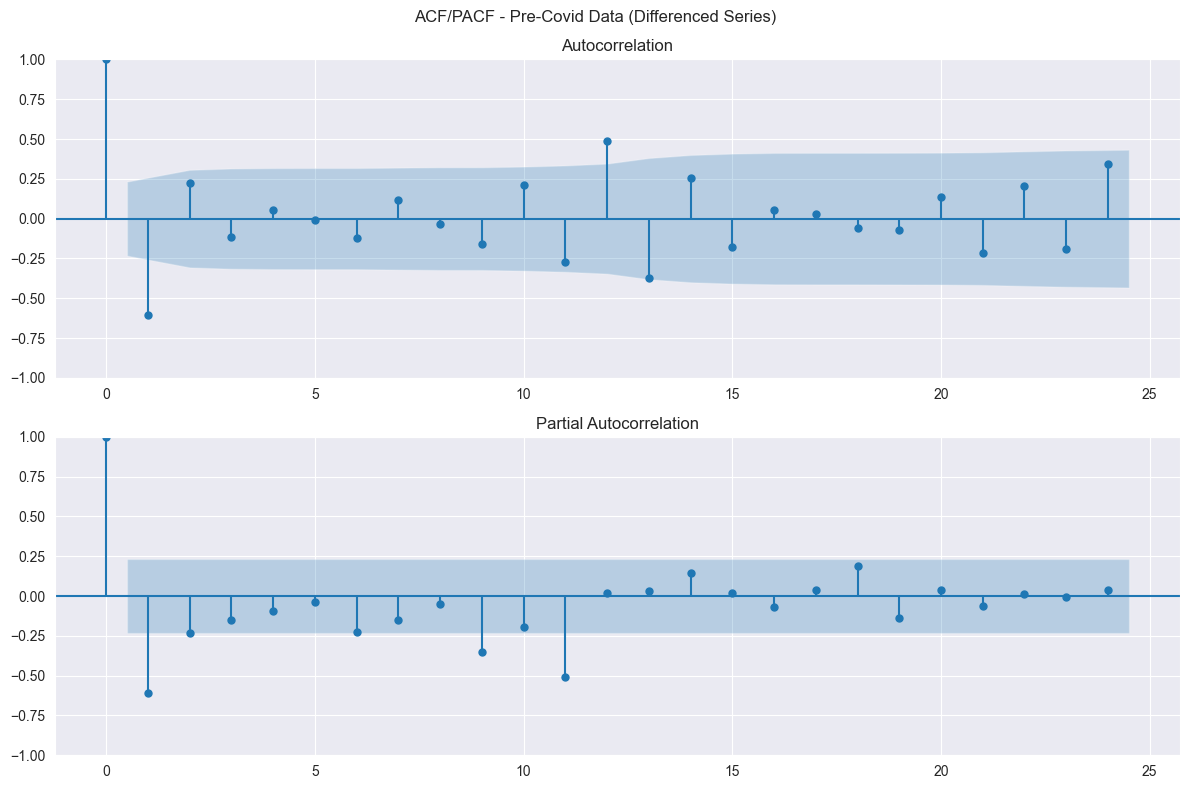

ADF Statistic (Post-Covid Data): -7.043
p-value: 0.000


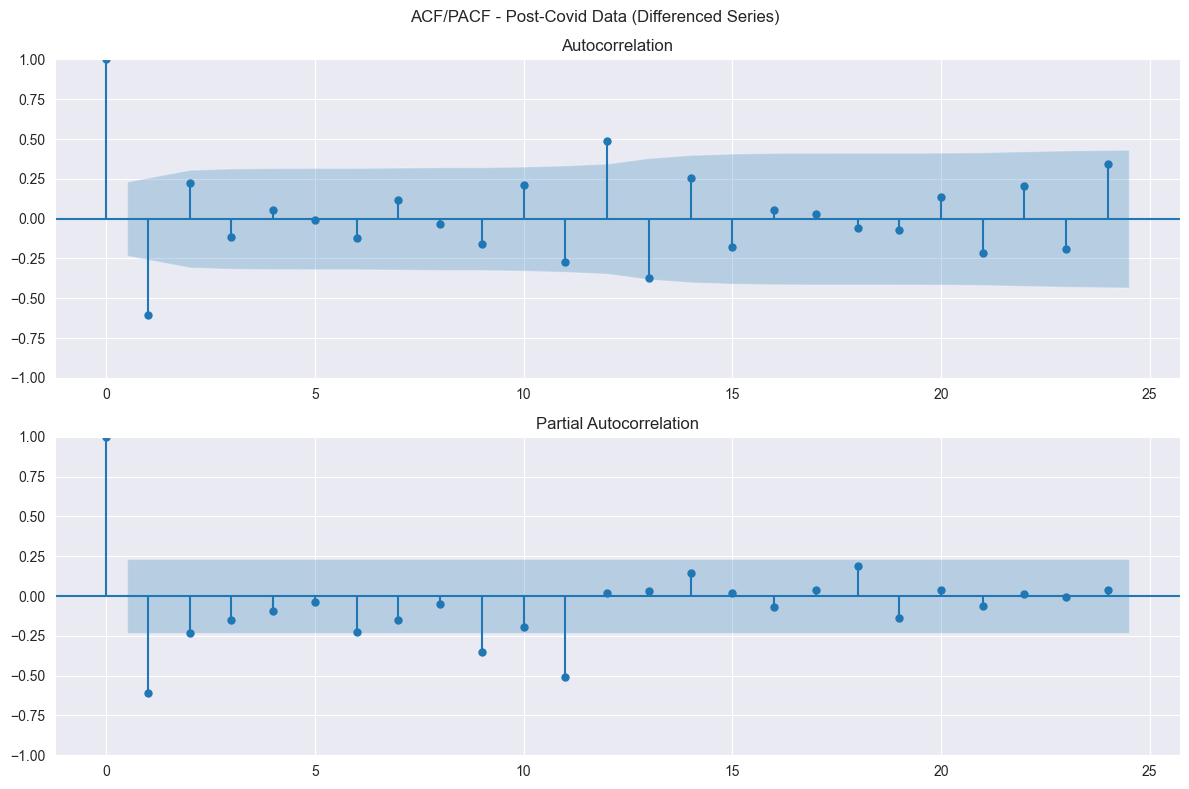

In [14]:
# Create subsets
pre_covid = monthly_counts[:'2019-12-31']
post_covid = monthly_counts['2020-12-31':]

pre_covid_diff = pre_covid.diff().dropna()
post_covid_diff = post_covid.diff().dropna()

plot_diff_acf_pacf(pre_covid_diff.burglary_count, 'Pre-Covid Data')
plot_diff_acf_pacf(pre_covid_diff.burglary_count, 'Post-Covid Data')

In [15]:
# Split data into train/test
train_post_covid = post_covid[:'2023-12-31']
test_post_covid = post_covid['2024-01-31':]  # Our test set is 2023-2025

# Fit SARIMA model (parameters determined through grid search)
order = (2, 1, 2)
seasonal_order = (2, 1, 2, 12)

model = SARIMAX(train_post_covid,
               order=order,
               seasonal_order=seasonal_order,
               enforce_stationarity=False,
               enforce_invertibility=False)

results = model.fit(disp=False)

# Model summary
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                     burglary_count   No. Observations:                   37
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood                   0.000
Date:                            Sat, 07 Jun 2025   AIC                             18.000
Time:                                    20:51:05   BIC                                nan
Sample:                                12-31-2020   HQIC                               nan
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7555         -0       -inf      0.000       0.755       0.755
ar.L2         -0.3608         -0   

In [16]:
# Forecast validation period
forecast_steps_post_covid = len(test_post_covid)
forecast_post_covid = results.get_forecast(steps=forecast_steps_post_covid)
forecast_mean = forecast_post_covid.predicted_mean
confidence_int = forecast_post_covid.conf_int()

# Calculate metrics
mse = mean_squared_error(test_post_covid, forecast_mean)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_post_covid, forecast_mean)

print(f'Validation Metrics:\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}')

Validation Metrics:
RMSE: 535.70
MAE: 433.20


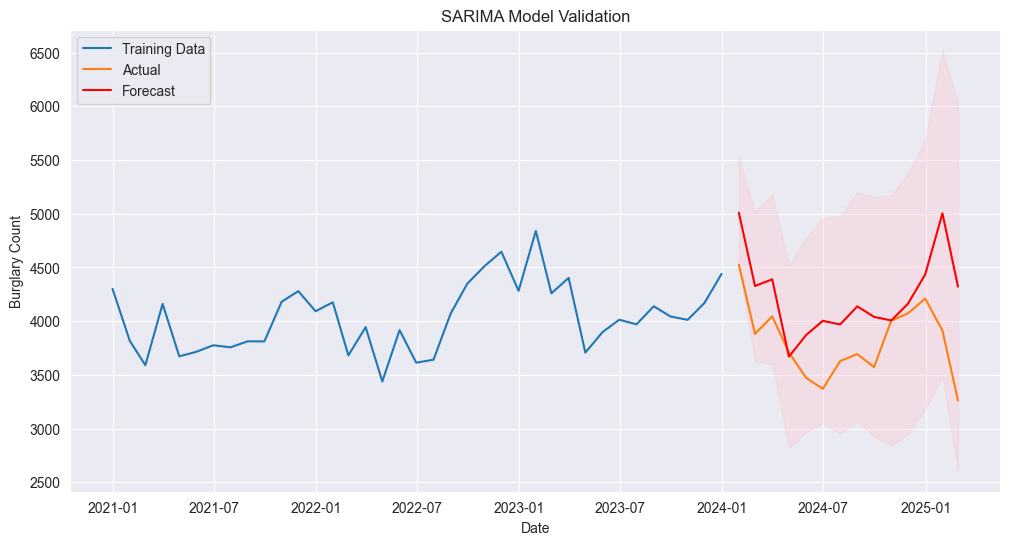

In [17]:
# Plot validation
plt.figure(figsize=(12, 6))
plt.plot(train_post_covid.index, train_post_covid, label='Training Data')
plt.plot(test_post_covid.index, test_post_covid, label='Actual')
plt.plot(test_post_covid.index, forecast_mean, label='Forecast', color='red')
plt.fill_between(test_post_covid.index,
                confidence_int.iloc[:, 0],
                confidence_int.iloc[:, 1],
                color='pink', alpha=0.3)
plt.title('SARIMA Model Validation')
plt.xlabel('Date')
plt.ylabel('Burglary Count')
plt.legend()
plt.show()

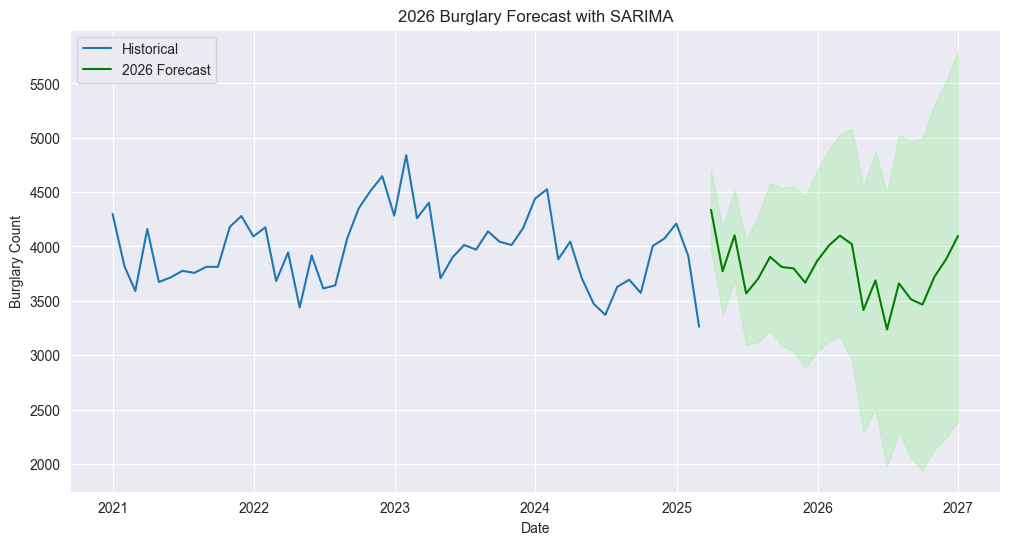

In [18]:
# Forecast 2026 for Post-covid model
future_steps = 22
post_covid_model = SARIMAX(train_post_covid,
                    order=order,
                    seasonal_order=seasonal_order)
post_covid_results = post_covid_model.fit(disp=False)

# Generate forecast
forecast_2026 = post_covid_results.get_forecast(steps=future_steps)
forecast_mean_2026 = forecast_2026.predicted_mean
forecast_conf_2026 = forecast_2026.conf_int()

# Create date index for 2026
forecast_index = pd.date_range(start=post_covid.index[-1] + pd.DateOffset(months=1),
                              periods=future_steps,
                              freq='M')

# Plot full series with forecast
plt.figure(figsize=(12, 6))
plt.plot(post_covid.index, post_covid, label='Historical')
plt.plot(forecast_index, forecast_mean_2026,
        label='2026 Forecast', color='green')
plt.fill_between(forecast_index,
                forecast_conf_2026.iloc[:, 0],
                forecast_conf_2026.iloc[:, 1],
                color='lightgreen', alpha=0.3)
plt.title('2026 Burglary Forecast with SARIMA')
plt.xlabel('Date')
plt.ylabel('Burglary Count')
plt.legend()
plt.show()

warnings.filterwarnings('default')